#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [64]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

#from bvcopula import SingleParamCopulaBase
from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
from torch.distributions import constraints, normal, studentT, distribution
from gpytorch.likelihoods.likelihood import Likelihood
from typing import Any
from torch import Tensor

class MixtureCopula(distribution.Distribution):
    '''
    This class represents Mixture copula
    '''
    has_rsample = True
    arg_constraints = {"theta": constraints.real, 
                       "mix": constraints.interval(0,1)} #TODO:write simplex constraint for leftmost dimention
    support = constraints.interval(0,1) # [0,1]
    
    def __init__(self, theta, mix, copulas, rotations=None, validate_args=None):
        self.theta = theta
        self.mix = mix
        self.copulas = copulas
        if rotations:
            self.rotations = rotations
        else:
            self.rotations = [None for _ in copulas]
        #TODO Check theta when there will be more than 1 param. Now it is checked by gpytorch
        batch_shape, event_shape = self.theta.shape, torch.Size([2])
        super(MixtureCopula, self).__init__(batch_shape, event_shape, validate_args=validate_args)
    
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(MixtureCopula, _instance)
        batch_shape = torch.Size(batch_shape)
        if batch_shape == torch.Size([]):
            batch_shape = torch.Size([1])
        theta_shape = batch_shape + torch.Size(self.event_shape[:-1])
        new.theta = self.theta.expand(theta_shape) 
        new.mix = self.mix.expand(theta_shape)
        super(MixtureCopula, new).__init__(batch_shape,
                                                self.event_shape,
                                                validate_args=False)
        new.copulas = self.copulas
        new.rotations = self.rotations
        new._validate_args = self._validate_args
        return new
    
    def rsample(self, sample_shape=torch.Size([])):
        shape = self._extended_shape(sample_shape) # now it is copulas x sample_size x 2 (event)
        
#         if sample_shape == torch.Size([]):   # not sure what to do with 1 sample
#             shape = torch.Size([1]) + shape
    
        samples = torch.zeros(size=shape[1:])
        if self.theta.is_cuda:
            get_cuda_device = self.theta.get_device()
            samples = samples.cuda(device=get_cuda_device)
        num_thetas = self.theta.shape[0]
        
        assert num_thetas==len(self.copulas)
        assert num_thetas==self.mix.shape[0]
        
        onehot = torch.distributions.one_hot_categorical.OneHotCategorical(
            probs=torch.einsum('i...->...i', self.mix)).sample()
        onehot = torch.einsum('...i->i...', onehot)
        onehot = onehot.type(torch.ByteTensor)
        for i,c in enumerate(copulas):
            samples[onehot[i],...] = c(self.theta[i,onehot[i]], rotation=self.rotations[i]).sample()
        
        return samples

    def log_prob(self, value):

#         if self._validate_args:
#             self._validate_sample(value)
        assert value.shape[-1] == 2 #check that the samples are pairs of variables
        log_prob = torch.zeros_like(self.theta[0]) # by default
        
        assert self.theta.shape[0]==len(self.copulas)
        assert self.mix.shape[0]==len(self.copulas)
        sum_mixes = self.mix.sum(dim=0)
        assert torch.allclose(sum_mixes,torch.ones_like(sum_mixes),atol=0.01)
        
        for i, c in enumerate(self.copulas):
            add = c(self.theta[i], rotation=self.rotations[i]).log_prob(value)+self.mix[i].log()
#             if torch.any(add>5.0):
#                 print(torch.max(add))
            log_prob += torch.exp(add) #torch.clamp(add,-float("Inf"),10.0))
            #TODO is it possible to vectorize this part?
        log_prob = log_prob.log()
        
#         log_prob[self.mix[0] < 0.01] = c(self.theta[1], rotation=self.rotations[1]).log_prob(value)[self.mix[0] < 0.01]
#         log_prob[self.mix[1] < 0.01] = c(self.theta[0], rotation=self.rotations[0]).log_prob(value)[self.mix[1] < 0.01]
    
        if torch.any(log_prob!=log_prob):
            print('Nan')
    
        return log_prob

In [192]:
#here we specify a 'true' latent function lambda
theta1 = lambda x: np.cos(2*np.pi*3*x)*5.+5. #*np.sin(2*np.pi*3*x+.6)
theta2 = lambda x: np.sin(2*np.pi*3*x)*5.+5. #*np.sin(2*np.pi*3*x+.6)
con = lambda x: np.cos(2*np.pi*1*x)*0.5+0.5 #*np.sin(2*np.pi*3*x+.6)

(1000, 2)


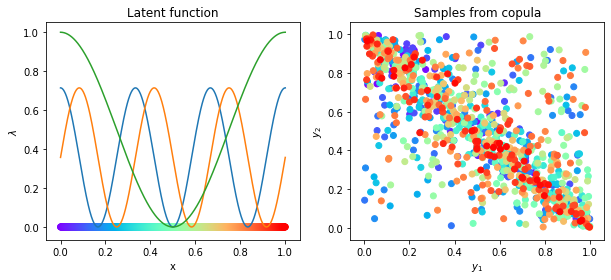

In [214]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e3)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,theta1(X)/14.)
lambdaf.plot(X,theta2(X)/14.)
lambdaf.plot(X,con(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

theta = torch.stack([torch.tensor([theta1(x) for x in X]),
                     torch.tensor([theta2(x) for x in X])]).float()
mix = torch.stack([torch.tensor([con(x) for x in X]),
                   torch.tensor([1-con(x) for x in X])]).float()
#likelihoods = [GaussianCopula_Likelihood(),FrankCopula_Likelihood()]
likelihoods = [ClaytonCopula_Likelihood(rotation='270°'),ClaytonCopula_Likelihood(rotation='90°')]
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
model = MixtureCopula(theta,mix,copulas,rotations=rotations)
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [215]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [216]:
from torch.distributions import constraints, normal, studentT
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.distributions import MultivariateNormal, base_distributions
from typing import Any
from torch import Tensor
    
class MixtureCopula_Likelihood(Likelihood):
    def __init__(self, likelihoods, **kwargs: Any):
        super(Likelihood, self).__init__()
        self._max_plate_nesting = 1
        self.likelihoods = likelihoods
        self.particles = torch.Size([100])
        
    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        function_samples = input.rsample(self.particles)
        thetas, mix = self.gplink_function(function_samples)
        copula = MixtureCopula(thetas, 
                               mix, 
                               [lik.copula for lik in self.likelihoods], 
                               [lik.rotation for lik in self.likelihoods])
        res = copula.log_prob(target).mean(0)
        assert res.dim()==1
        return res.sum()

    def gplink_function(self, f: Tensor) -> Tensor:
        """
        GP link function transforms the GP latent variable `f` into :math:`\theta`,
        which parameterizes the distribution in :attr:`forward` method as well as the
        log likelihood of this distribution defined in :attr:`expected_log_prob`.
        """
        num_copulas = len(self.likelihoods)
        assert 2*num_copulas-1==f.shape[-2] #likelihoods + mixing concentrations - 1 (dependent)
        
        thetas, mix = [], []
        last_con = torch.ones_like(f[...,0,:])
        for i, lik in enumerate(self.likelihoods):
            thetas.append(lik.gplink_function(f[...,i,:]))
            if i!=(num_copulas-1):
                prob = base_distributions.Normal(0,1).cdf(f[...,i+num_copulas,:])
                last_con -= prob
                mix.append(prob)
        mix.append(last_con)
        assert torch.all(torch.stack(thetas)==torch.stack(thetas))
        assert torch.all(torch.stack(mix)==torch.stack(mix))
        return torch.stack(thetas), torch.stack(mix)

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> MixtureCopula:
        thetas, mix = self.gplink_function(function_samples)
        return MixtureCopula(thetas, 
                             mix, 
                             [lik.copula for lik in self.likelihoods], 
                             [lik.rotation for lik in self.likelihoods])


In [217]:
from gpytorch.utils.interpolation import Interpolation, left_interp
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational.variational_strategy import VariationalStrategy

class GridInterpolationVariationalStrategy(VariationalStrategy):
    def __init__(self, model, num_tasks, 
                 grid_size, grid_bounds, variational_distribution):
        grid = torch.zeros(grid_size, len(grid_bounds))
        for i in range(len(grid_bounds)):
            grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
            grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)

        inducing_points = torch.zeros(int(pow(grid_size, len(grid_bounds))), len(grid_bounds))
        prev_points = None
        for i in range(len(grid_bounds)):
            for j in range(grid_size):
                inducing_points[j * grid_size ** i : (j + 1) * grid_size ** i, i].fill_(grid[j, i])
                if prev_points is not None:
                    inducing_points[j * grid_size ** i : (j + 1) * grid_size ** i, :i].copy_(prev_points)
            prev_points = inducing_points[: grid_size ** (i + 1), : (i + 1)]

        super(GridInterpolationVariationalStrategy, self).__init__(
            model, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        object.__setattr__(self, "model", model)

        self.register_buffer("grid", grid)
        self.num_tasks = num_tasks

    def _compute_grid(self, inputs):
        if inputs.ndimension() == 1:
            inputs = inputs.unsqueeze(1)

        interp_indices, interp_values = Interpolation().interpolate(self.grid, inputs)
        return interp_indices, interp_values

    def forward(self, x):
        variational_distribution = self.variational_distribution.variational_distribution
        
        # Get interpolations
        interp_indices, interp_values = self._compute_grid(x)
        interp_indices = interp_indices.expand(torch.Size([self.num_tasks])+interp_indices.shape)
        interp_values = interp_values.expand(torch.Size([self.num_tasks])+interp_values.shape)

        # Compute test mean
        # Left multiply samples by interpolation matrix
        predictive_mean = left_interp(interp_indices, interp_values, variational_distribution.mean.unsqueeze(-1))
        predictive_mean = predictive_mean.squeeze(-1)

        # Compute test covar
        predictive_covar = InterpolatedLazyTensor(
            variational_distribution.lazy_covariance_matrix,
            interp_indices,
            interp_values,
            interp_indices,
            interp_values,
        )

        output = MultivariateNormal(predictive_mean, predictive_covar)
        return output

class Mixed_GPInferenceModel(gpytorch.models.AbstractVariationalGP):
    def __init__(self, likelihood, num_tasks, prior_rbf_length=0.1, 
                 grid_size = 128, grid_bonds = [(0, 1)]):
        # Define all the variational stuff
        variational_distribution = \
        gpytorch.variational.CholeskyVariationalDistribution(grid_size, 
                                                              batch_shape=torch.Size([num_tasks]))
#         variational_strategy = gpytorch.variational.VariationalStrategy(
#             self,
#             train_x,
#             variational_distribution
#         )
        variational_strategy = GridInterpolationVariationalStrategy(
            self,
            num_tasks,
            grid_size, 
            grid_bonds, 
            variational_distribution
        )
        
        # Standard initializtation
        super(Mixed_GPInferenceModel, self).__init__(variational_strategy) 
        self.likelihood = likelihood
        
        # Mean, covar
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.mean_module = gpytorch.means.ConstantMean(batch_size=num_tasks)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, batch_size=num_tasks, ard_num_dims=1),
            batch_size=num_tasks, ard_num_dims=None
        )
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 10.0) #variance does not matter much
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        assert torch.all(mean==mean)
        mmn = gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)
        return mmn

In [218]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
model = Mixed_GPInferenceModel(MixtureCopula_Likelihood(likelihoods), 2*len(likelihoods)-1, \
                               prior_rbf_length=0.2, grid_size=grid_size).cuda(device=0)

In [219]:
# train the model

base_lr = 1e-4
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .1},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .01} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1]))
            ))
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p < 0.001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
#         for par in model.parameters():
#             grad = par.grad.data
#             if torch.nonzero(grad!=grad).shape[0]!=0:
#                 print('NaN grad')
#             nans+=torch.nonzero(grad!=grad).shape[0]
#             if torch.any(grad.abs()==float('inf')):
#                 print("Grad inf... fixing...")
#                 grad = torch.clamp(grad,-1.,1.)
#             grad[grad!=grad] = 0.0
#             par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.0001
Iter 100/2000 - Loss: -0.506   lengthscale: [0.136638  0.1359868 0.1798814], dLoss: 0.0, mean f: -0.181, dmean: 0.39
Iter 200/2000 - Loss: -0.607   lengthscale: [0.09247795 0.0937418  0.17630856], dLoss: 0.0803, mean f: -0.32, dmean: 0.418


AssertionError: 

(296, 3, 128)


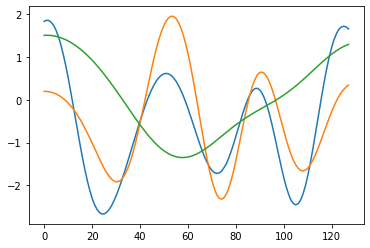

In [220]:
print(np.shape(means))
plt.plot(means[-1][0])
plt.plot(means[-1][1])
plt.plot(means[-1][2])
losses[losses!=losses] = 0

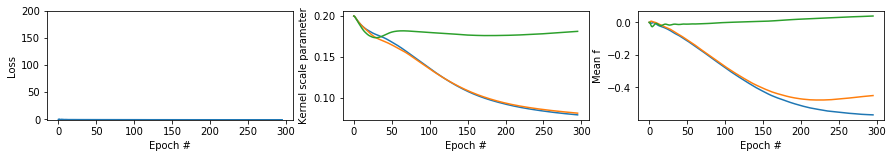

In [221]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [222]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

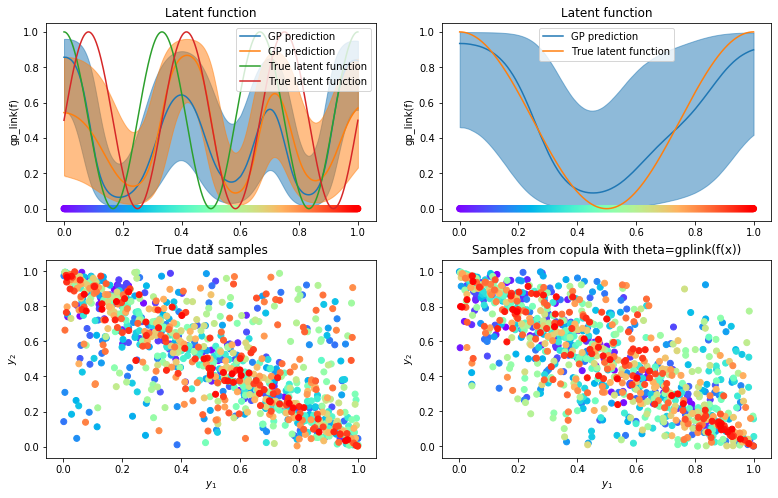

In [223]:
# visualize the result
fig, ax = plt.subplots(2,2,figsize=(13, 8))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
scale = [np.max(np.abs(theta1(testX))),np.max(np.abs(theta2(testX)))]
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)
 
for t,l,u,sc in zip(thetas,thetas_low,thetas_upp,scale):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,0].plot(testX, F_mean/sc, label = 'GP prediction')
    ax[0,0].fill_between(testX, l.detach().cpu().numpy()/sc,
                    u.detach().cpu().numpy()/sc, color=line.get_color(), alpha=0.5)

ax[0,0].plot(testX,theta1(testX)/scale[0], label = 'True latent function')
ax[0,0].plot(testX,theta2(testX)/scale[1], label = 'True latent function')
ax[0,0].scatter(X,np.zeros_like(X),color=colors)
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('gp_link(f)')
ax[0,0].set_title('Latent function')
ax[0,0].legend()

for t,l,u in zip(mixes[:-1],mixes_low[:-1],mixes_upp[:-1]):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,1].plot(testX, F_mean, label = 'GP prediction')
    ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,1].plot(testX,con(testX), label = 'True latent function')
ax[0,1].scatter(X,np.zeros_like(X),color=colors)
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('gp_link(f)')
ax[0,1].set_title('Latent function')
ax[0,1].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
ax[1,1].scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for c in [0,1]:
    ax[1,c].set_xlabel('$y_1$')
    ax[1,c].set_ylabel('$y_2$')
ax[1,0].set_title('True data samples')
ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()